# Imports

In [ ]:
! git clone https://github.com/ai-forever/sage.git

In [ ]:
cd sage

In [ ]:
! pip install .
! pip install -r requirements.txt

In [1]:
import os
import sage

# Statistic-based spelling corruption

As a name suggests, Statistic-bases spelling corruption (SBSC) automatically
insert errors in correct sentences based on some available statistics. 

In the case of SBSC, statistics are gathered from annotated parallel corpus that
consists of correct texts and their spoiled counterparts. SBSC scans through pairs
of texts, detects typos and errors and their corresponding positions, aggregates in 
appropriate discrete distributions and then sample from them to purposefully violate
spelling when applied on correct sentences. 

More on this in our paper https://www.dialog-21.ru/media/5914/martynovnplusetal056.pdf

As stated in the description, SBSC needs labeled parallel corpus, so it can
reproduce analogous errors on new data. SBSC accepts either datasets available on 
HF hub, or stored locally in single file (`data.csv`) or in separate files (`sources.txt` and
`corrections.txt`). 

API of SBSC is as flexible as one can imagine. Basically you instantiate 
object of `SBSCCorruptor` with `SBSCConfig`. `SBSCConfig` can be initialized from available dataset (HF hub or local), pre-obtained statistics or from combination of both. 

In [2]:
from sage.spelling_corruption import SBSCConfig, SBSCCorruptor
from sage.utils import DatasetsAvailable, load_available_dataset_from_hf, draw_and_save_errors_distributions_comparison_charts
from sage.spelling_corruption.sbsc.labeler import process_mistypings

## From HF dataset

Easy as it sounds:

1. Choose available dataset at https://huggingface.co/datasets/ai-forever/spellcheck_benchmark;
2. Instantiate `SBSCConfig` with selected dataset name;
3. `SBSCCorruptor` automatically loads dataset and gathers statistics from it;
4. Now you can use `SBSCCorruptor` to insert errors in correct texts!

In [ ]:
# `SBSCConfig` defaults to RUSpellRU dataset from HF hub

corruptor = SBSCCorruptor.from_default_config()

That is it really! You now can spoil the text and expect errors to be similar to those
in RUSpellRU! But lets check this assumption out. Algorithm would be as follows:

1. Load source dataset;
2. Scan original errors and gather corresponding statistics from source dataset;
3. Take correct sentences from source dataset and use SBSC to corrupt them;
4. Scan generated errors and gather corresponding statistics from obtrained sentences;
5. Compare statistics and see how close they are!

In [ ]:
# Load source dataset to see whether SBSC is able to mimic its errors.
# But first gather original errors:

sources, corrections = load_available_dataset_from_hf("RUSpellRU", for_labeler=True, split="train")
ruspellru_stats, ruspellru_confusion_matrix, ruspellru_typos_cnt = process_mistypings(sources, corrections)

In [ ]:
# Corruptor allows both `corrupt` and `batch_corrupt` methods.

# Here we corrupt correct sentences from RUSpellRU
# to compare them with original errors afterwards. 

spoiled_sentences = corruptor.batch_corrupt(corrections)

In [ ]:
# Manually collect statistics

sbsc_stats, sbsc_confusion_matrix, sbsc_typos_cnt = process_mistypings(spoiled_sentences, corrections)

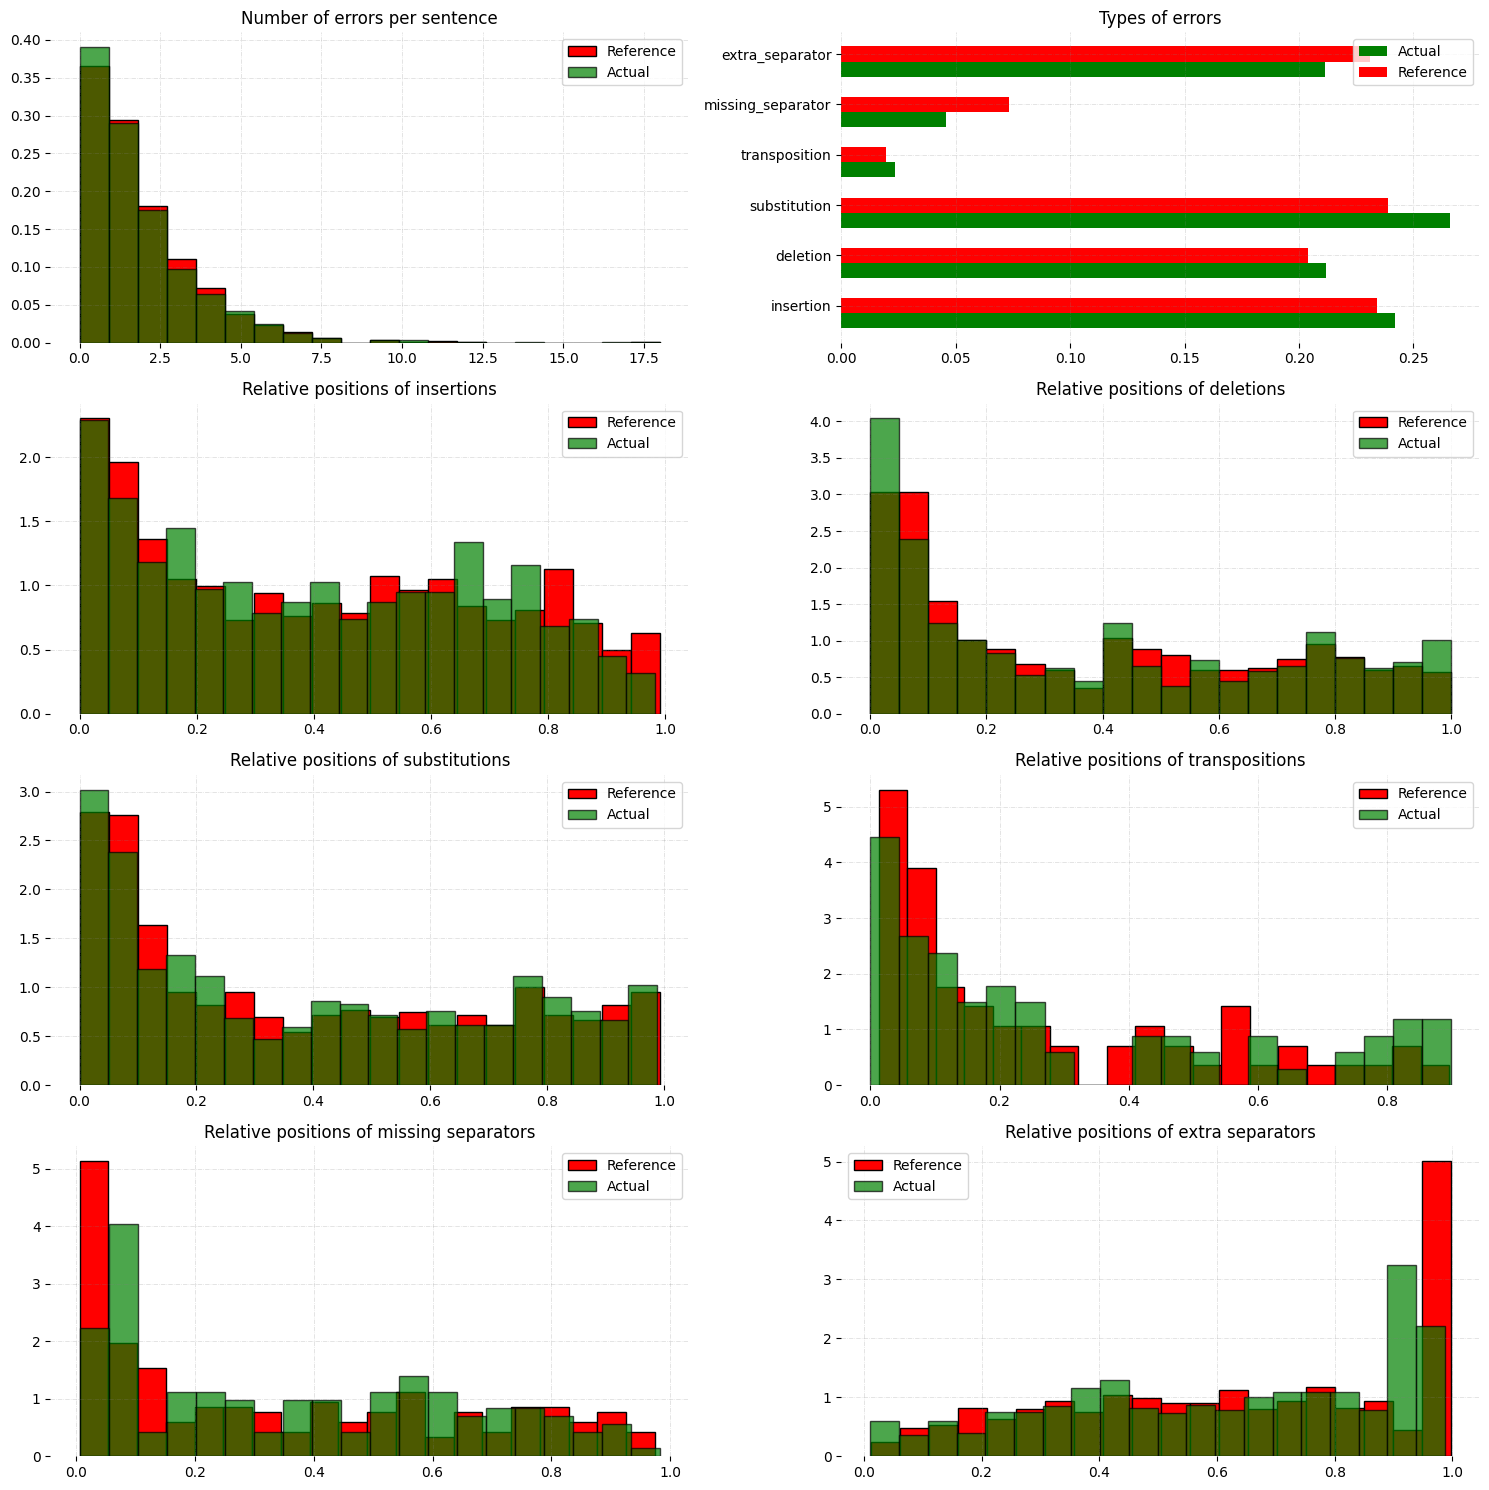

In [7]:
# Lets see how good SBSC is

draw_and_save_errors_distributions_comparison_charts(
    actual_typos_cnt = sbsc_typos_cnt,
    reference_typos_cnt=ruspellru_typos_cnt,
    actual_stats=sbsc_stats,
    reference_stats=ruspellru_stats,
    path_to_save="ruspellru_sbsc.jpg"
)

## From local dataset

You do the same steps as above, but you provide locally stored dataset instead. 

A few reminders on how to store your dataset:

1. It is either two files `sources.txt` and `corrections.txt` in one folder, or one file `data.csv` with `source` and `correction` fields;
2. Check that `sources.txt` and `corrections.txt` account for the same number of lines;
3. Check that `data.csv` does not have any nans or empty lines;
4. Past only path to folder, where your dataset is located, `SBSCCorruptor` automatically finds appropriate dataset;

Currently, SAGE can operate over the Russian and English languages. We plan to grow our SAGE (:-)) and expand the range of available languages. Do not forget to put appropriate language code when working with custom config.

In [8]:
from sage import AVAILABLE_LANG_CODES

In [9]:
AVAILABLE_LANG_CODES

['ru', 'en']

In [ ]:
# Instantitate (make sure to be inside sage directory)

config = SBSCConfig(
    lang="ru",
    reference_dataset_name_or_path=os.path.join(os.getcwd(), "data", "example_data", "RUSpellRU")
)
corruptor = SBSCCorruptor.from_config(config)

In [ ]:
# Corrupt

spoiled_sentences = corruptor.batch_corrupt(corrections)

In [ ]:
# Check

sbsc_stats, sbsc_confusion_matrix, sbsc_typos_cnt = process_mistypings(spoiled_sentences, corrections)

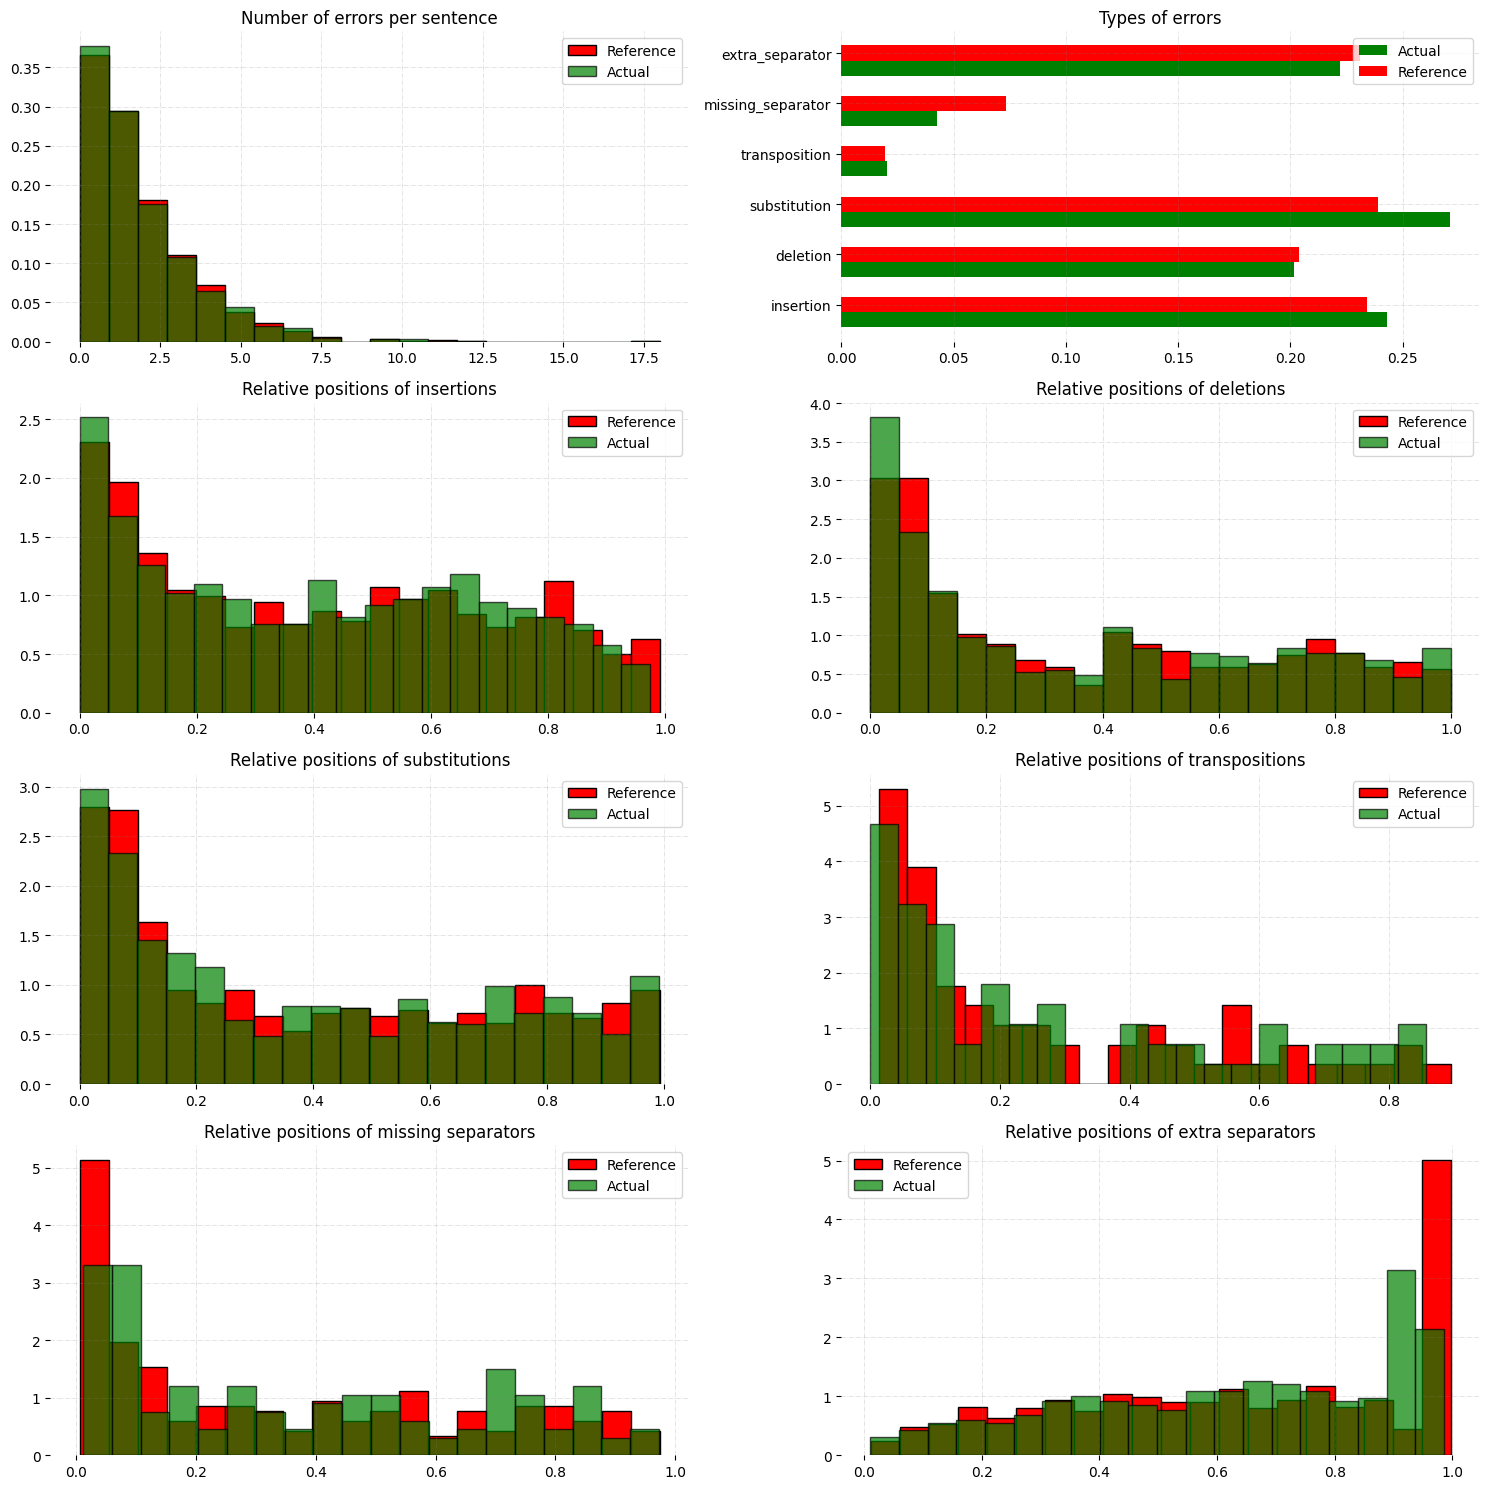

In [13]:
# Lets see how good SBSC is

draw_and_save_errors_distributions_comparison_charts(
    actual_typos_cnt = sbsc_typos_cnt,
    reference_typos_cnt=ruspellru_typos_cnt,
    actual_stats=sbsc_stats,
    reference_stats=ruspellru_stats,
    path_to_save="ruspellru_sbsc.jpg"
)

## From obtained statistics

Algorithm is trivial as well:

1. Load dataset from https://huggingface.co/datasets/ai-forever/spellcheck_benchmark or provide your own locally;
2. Use `process_mistypings` to obtain statistics;
3. Instantiate `SBSCConfig` with acquired statistics and initialize `SBSCCorruptor`;
4. Now you can use SBSCCorruptor to insert errors in correct texts!

In [ ]:
# Load / provide dataset and gather statistics

sources, corrections = load_available_dataset_from_hf("RUSpellRU", for_labeler=True, split="train")
reference_stats, reference_confusion_matrix, reference_typos_cnt = process_mistypings(sources, corrections)

In [15]:
# Instantiate

config = SBSCConfig(
    lang="ru",
    typos_count=reference_typos_cnt,
    stats=reference_stats,
    confusion_matrix=reference_confusion_matrix,
)
corruptor = SBSCCorruptor.from_config(config)

In [ ]:
# Corrupt

spoiled_sentences = corruptor.batch_corrupt(corrections)

In [ ]:
# Check

sbsc_stats, sbsc_confusion_matrix, sbsc_typos_cnt = process_mistypings(spoiled_sentences, corrections)

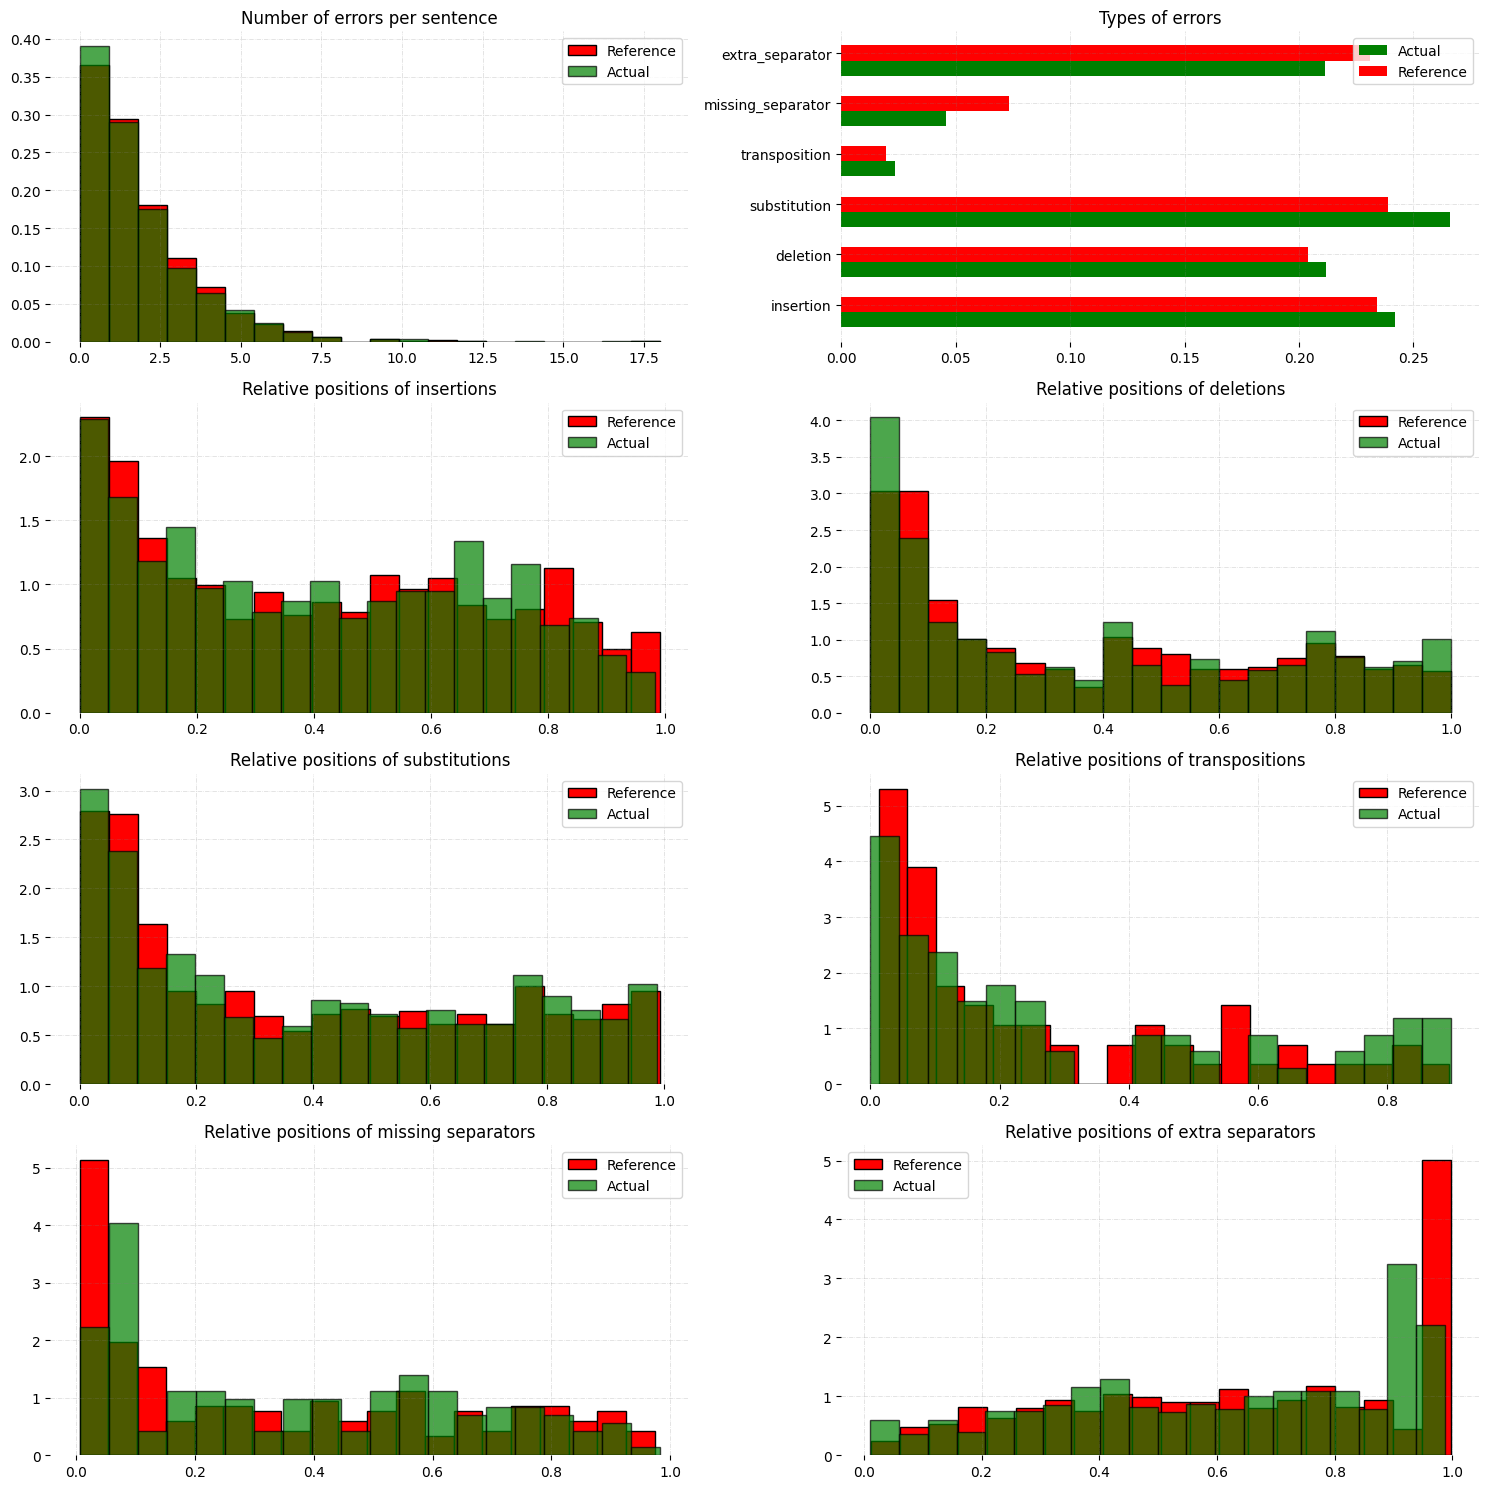

In [18]:
# Lets see how good SBSC is

draw_and_save_errors_distributions_comparison_charts(
    actual_typos_cnt = sbsc_typos_cnt,
    reference_typos_cnt=reference_typos_cnt,
    actual_stats=sbsc_stats,
    reference_stats=reference_stats,
    path_to_save="ruspellru_sbsc.jpg"
)

## From both

Imagine you want to build your own errors statistics from existing blocks, but with a little bit of twist.

For example, you want another distribution of number of errors per sentence, or another substitution in confusion matrix. You can do it in `SBSCCorruptor`.

Lets say we want the same statistics from RUSpellRU, but with more errors per sentence.

In [ ]:
# Instantiate

config = SBSCConfig(
    lang="ru",
    typos_count=[10],
    reference_dataset_name_or_path="RUSpellRU",
)
corruptor = SBSCCorruptor.from_config(config)

In [ ]:
# Corrupt

spoiled_sentences = corruptor.batch_corrupt(corrections)

In [ ]:
# Check

sbsc_stats, sbsc_confusion_matrix, sbsc_typos_cnt = process_mistypings(spoiled_sentences, corrections)

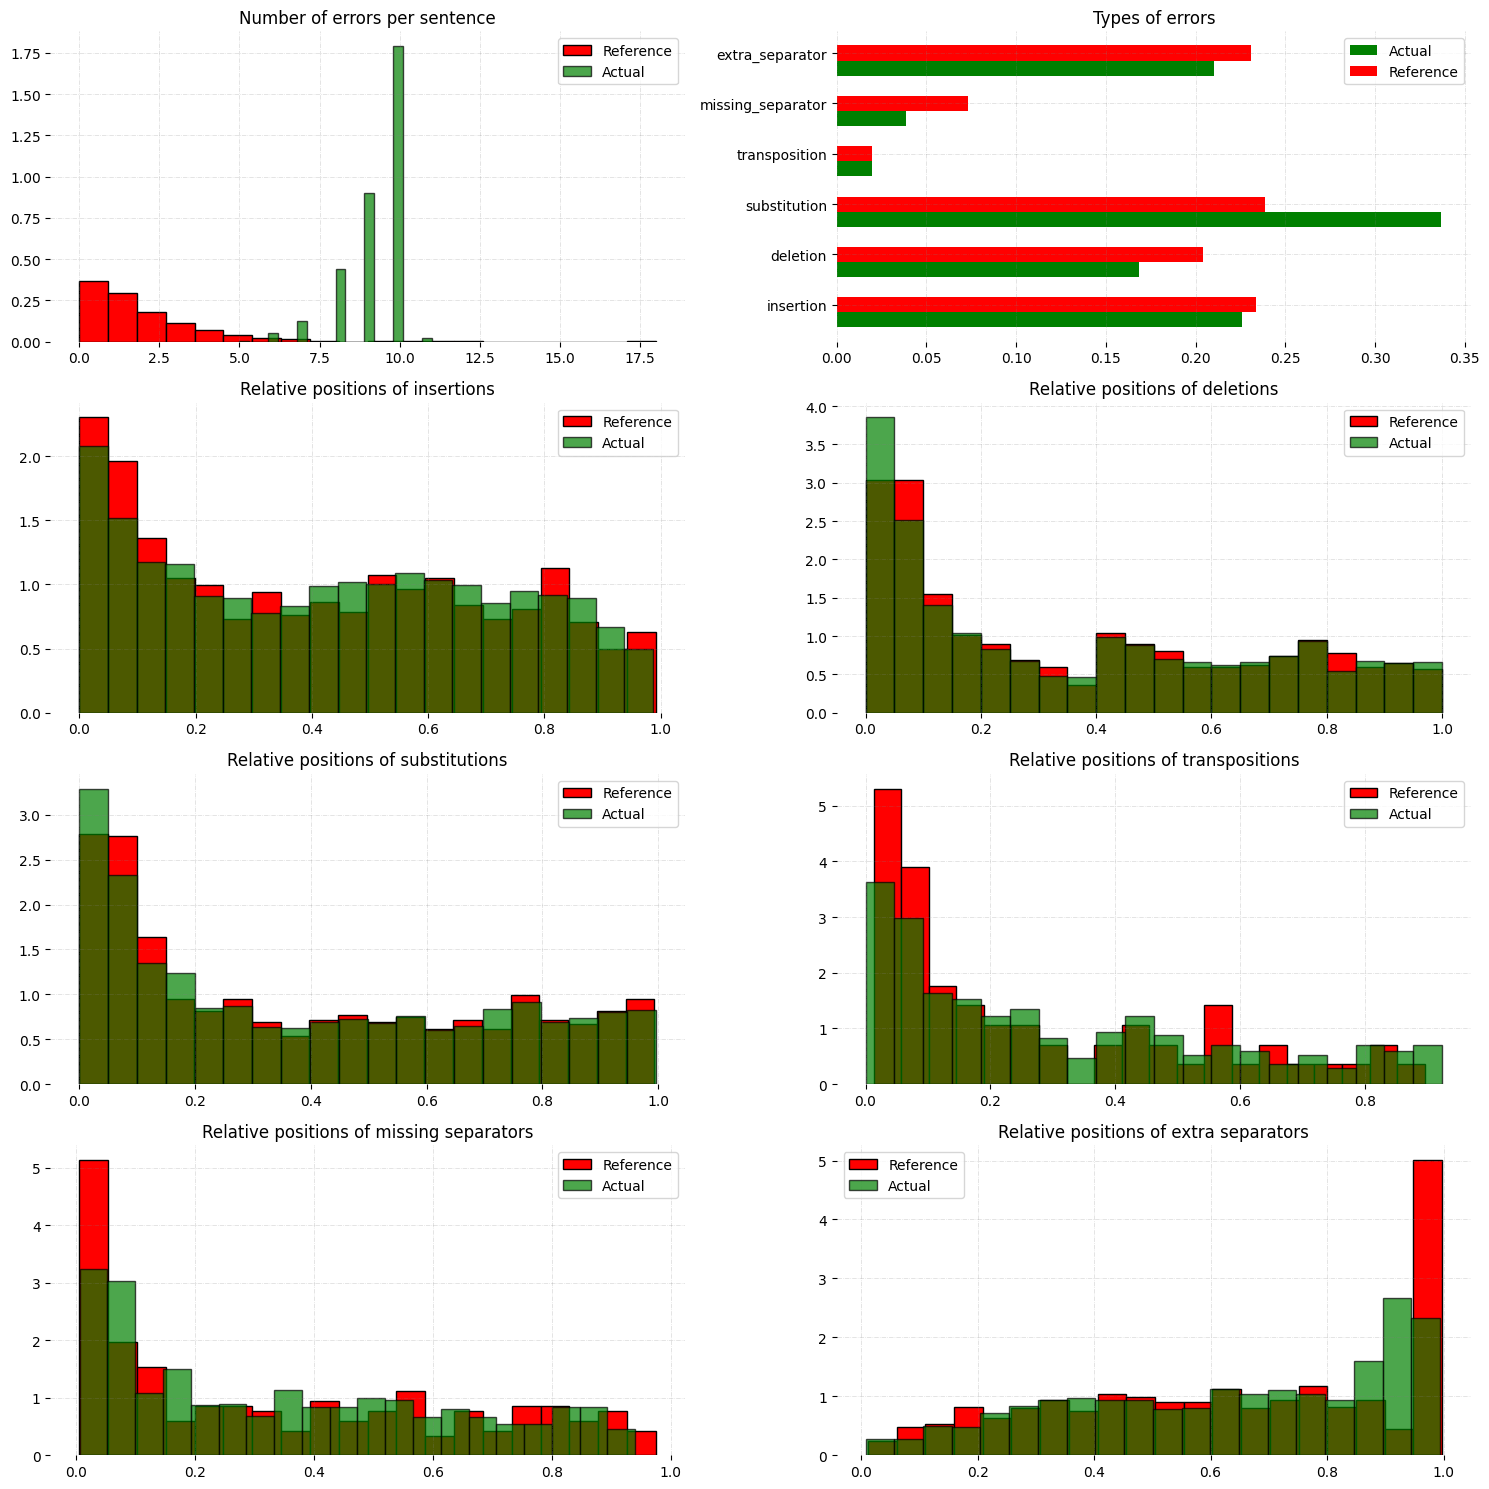

In [22]:
# Lets see how good SBSC is

draw_and_save_errors_distributions_comparison_charts(
    actual_typos_cnt = sbsc_typos_cnt,
    reference_typos_cnt=ruspellru_typos_cnt,
    actual_stats=sbsc_stats,
    reference_stats=ruspellru_stats,
    path_to_save="ruspellru_sbsc.jpg"
)

We increased number of errors, but other distributions are almost the same.

## For English 

In [ ]:
# Instantiate (make sure to be inside sage directory)

config = SBSCConfig(
    lang="en",
    reference_dataset_name_or_path=os.path.join(os.getcwd(), "data", "example_data", "jfleg")
)
corruptor = SBSCCorruptor.from_config(config)

In [ ]:
# Load dataset (make sure to be inside sage directory)

with open(os.path.join(os.getcwd(), "data", "example_data", "jfleg", "corrections.txt")) as corr_file, \
     open(os.path.join(os.getcwd(), "data", "example_data", "jfleg", "sources.txt")) as src_file:
    corrections = corr_file.read().split("\n")
    sources = src_file.read().split("\n")
    
corrections.pop()
sources.pop()

jfleg_stats, jfleg_confusion_matrix, jfleg_typos_cnt = process_mistypings(sources, corrections)

In [ ]:
# Corrupt

spoiled_sentences = corruptor.batch_corrupt(corrections)

In [ ]:
# Check

sbsc_stats, sbsc_confusion_matrix, sbsc_typos_cnt = process_mistypings(spoiled_sentences, corrections)

/Users/20289689/.conda/envs/sage_testing/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


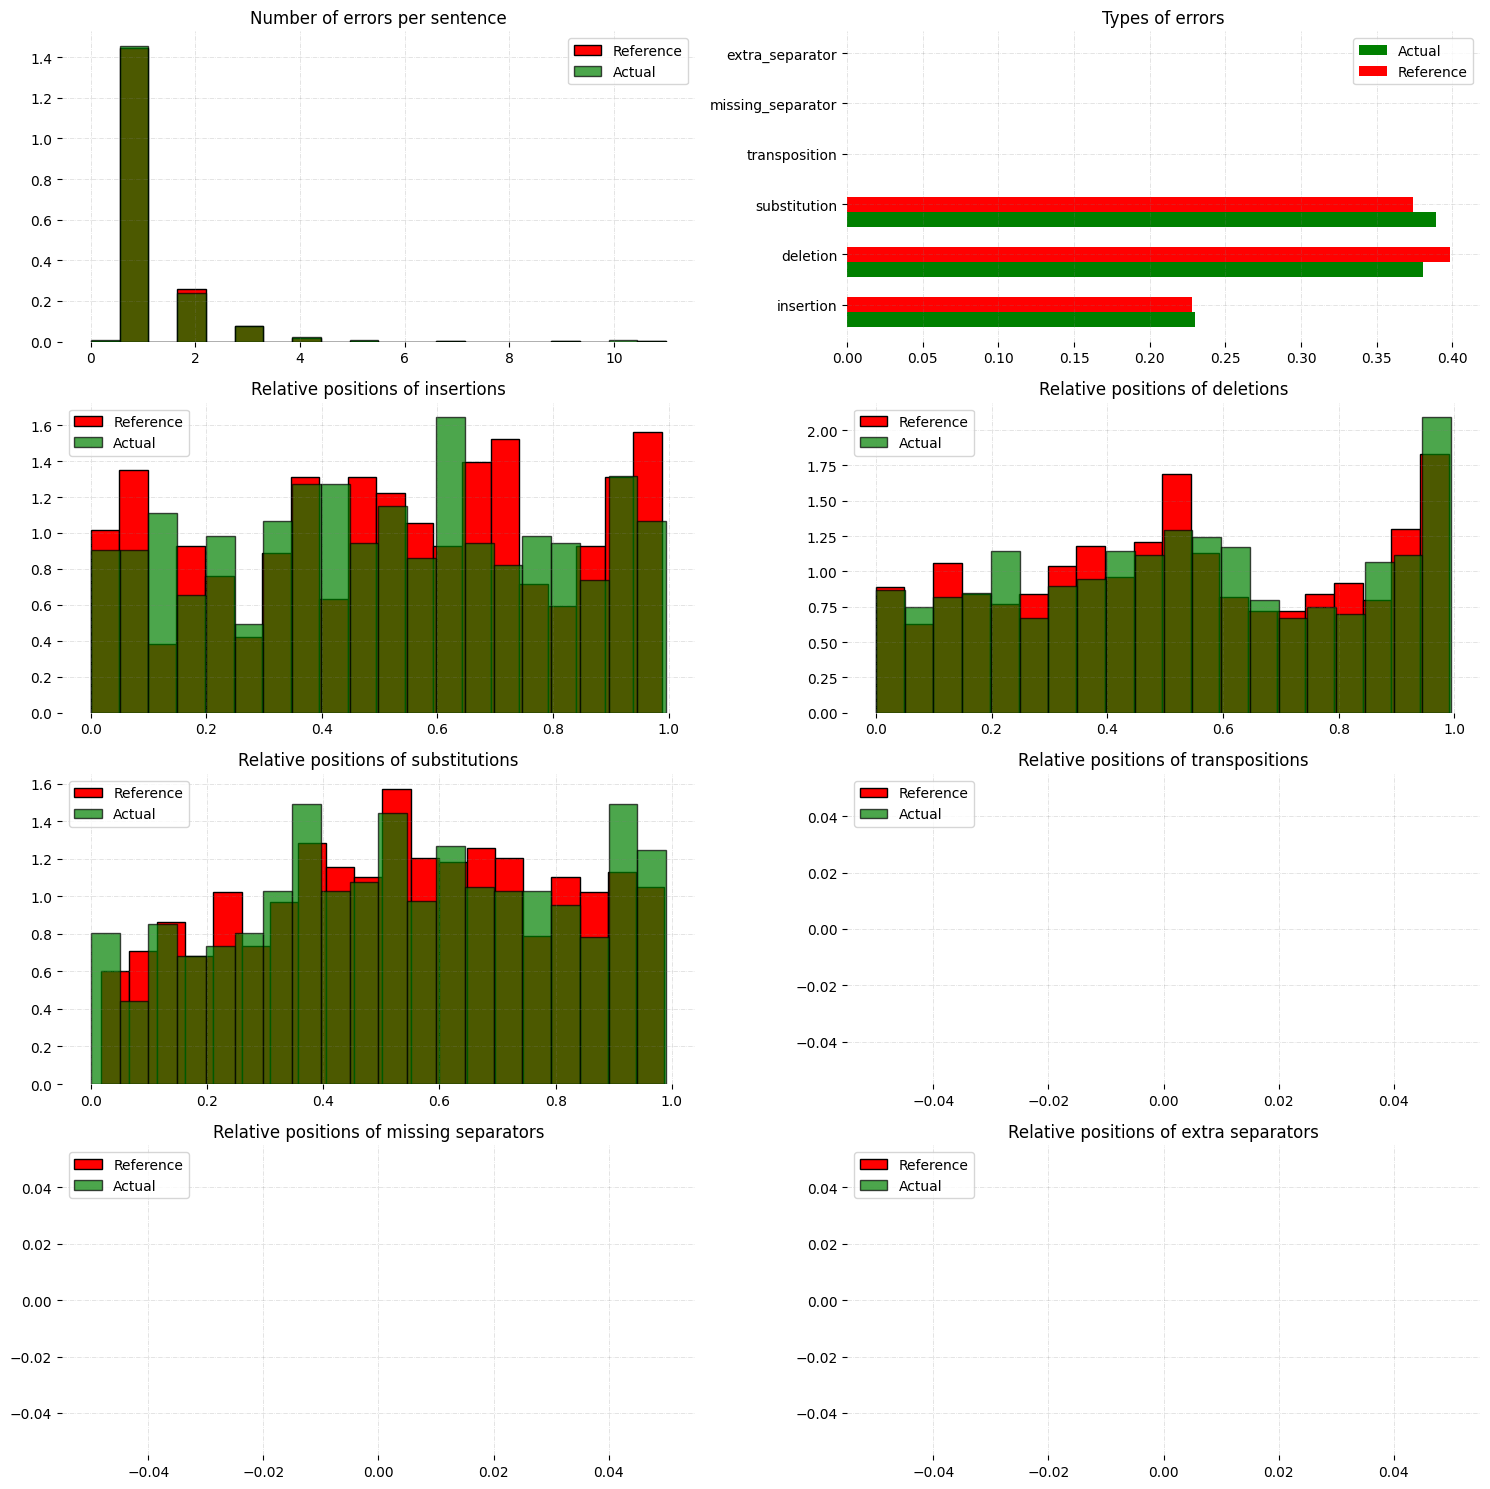

In [27]:
# Lets see how good SBSC is

draw_and_save_errors_distributions_comparison_charts(
    actual_typos_cnt = sbsc_typos_cnt,
    reference_typos_cnt=jfleg_typos_cnt,
    actual_stats=sbsc_stats,
    reference_stats=jfleg_stats,
    path_to_save="jfleg_sbsc.jpg"
)

# Augmentex

Credit for this section goes to @Mark Baushenko and @Alexander Abramov

Augmentex operates over most popular mistypings and common spelling errors gathered from open statistics as well as rule-based approaches and various heuristics. 

It offers two levels of granuality when working with text corruption:

1. Character level:

    a. shift - randomly swaps upper / lower case in a string;
    
    b. orfo - substitute correct characters with their common incorrect counterparts;
    
    c. typo - substitute correct characters as if they are mistyped on a keyboard;
    
    d. delete - delete random character;
    
    e. multiply - multiply random character;
    
    f. swap - swap two adjacent characters;
    
    g. insert - insert random character;
    
    
2. Word level:
    
    a. replace - replace a random word in its incorrect counterpart;
    
    b. delete - delete random word;
    
    c. swap - swap two random words;
    
    d. stopword - add random words from stop-list;
    
    e. reverse - change a case of the first letter of a random word;
    

More about Augmentex in our paper https://www.dialog-21.ru/media/5914/martynovnplusetal056.pdf

In [28]:
from sage.spelling_corruption import CharAugConfig, CharAugCorruptor, WordAugConfig, WordAugCorruptor

In [29]:
text = "Привет, как дела?"

## Character level

In [53]:
# Instantiate

config = CharAugConfig(
    unit_prob=0.3, # proportion of characters that is going to undergo edits
    min_aug=1, # minimum number of edits
    max_aug=5, # maximum number of edits 
    mult_num=3 # `multiply` edit
)
corruptor = CharAugCorruptor.from_config(config)

In [63]:
# Random edit

corruptor.corrupt(text)

'Привет, как дЕЛа?'

In [55]:
# Shift

corruptor.corrupt(text, action="shift")

'ПРивет, как дЕла?'

In [56]:
# Orfo

corruptor.corrupt(text, action="orfo")

'Ппивет,щкакядвла?'

In [57]:
# Typo

corruptor.corrupt(text, action="typo")

'Ппивет, как д5ла?'

In [58]:
# Delete

corruptor.corrupt(text, action="delete")

'Пивет,какдла?'

In [59]:
# Multiply

corruptor.corrupt(text, action="multiply")

'Прривет, как дела?'

In [60]:
# Swap

corruptor.corrupt(text, action="swap")

'рПивет, ка кедла?'

In [61]:
# Insert

corruptor.corrupt(text, action="insert")

'Прыивет, ёгкак цдевла?'

In [62]:
# Edits over batch of samples. `batch_prob` represents the proportion of samples in batch
# that is going to undergo edits.

text_list = [text] * 10
corruptor.batch_corrupt(text_list, action="insert", batch_prob=0.5)

['Пряцившет, как чделра?',
 'Привет, как дела?',
 'Привет, как дела?',
 'Привет, как дела?',
 'Преивект, ёкакв оделпшцла?ш',
 'Привет, как дела?',
 'Привет,ж ькаскн дегла?',
 'Приёвет, шклак деплэа?',
 'Привет, как дела?',
 'Привет, как дела?']

## Word level

In [64]:
# Instantiate

config = WordAugConfig(
    unit_prob=0.4, # proportion of characters that is going to undergo edits
    min_aug=1, # minimum number of edits
    max_aug=5, # maximum number of edits 
)
corruptor = WordAugCorruptor.from_config(config)

In [65]:
# Random action

corruptor.corrupt(text)

'Привет, как вла?'

In [66]:
# Replace

corruptor.corrupt(text, action="replace")

'Привет, как дела?'

In [67]:
# Delete

corruptor.corrupt(text, action="delete")

'как дела?'

In [68]:
# Swap 

corruptor.corrupt(text, action="swap")

'дела? как Привет,'

In [69]:
# Stopword 

corruptor.corrupt(text, action="stopword")

'же Привет, как дела?'

In [70]:
# Reverse 

corruptor.corrupt(text, action="reverse")

'привет, как дела?'

In [71]:
# Edits over batch of samples. `batch_prob` represents the proportion of samples in batch
# that is going to undergo edits.

text_list = [text] * 10
corruptor.batch_corrupt(text_list, action="stopword", batch_prob=0.5)

['Привет, как ага дела?',
 'Привет, как дела?',
 'Привет, как дела?',
 'Привет, как дела?',
 'Привет, как можно ж дела?',
 'Привет, как дела?',
 'блин Привет, как дела?',
 'Привет, как не дела?',
 'Привет, как дела?',
 'Привет, как дела?']